In [ ]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

In [ ]:
def import_stock_data(tickers, start = '2010-1-1'):
    data = pd.DataFrame()
    if len([tickers]) ==1:
        data[tickers] = wb.DataReader(tickers, data_source='yahoo', start = start)['Adj Close']
        #data = pd.DataFrame(data)
    else:
        for t in tickers:
            data[t] = wb.DataReader(t, data_source='yahoo', start = start)['Adj Close']
    return(data)

In [ ]:
def log_returns(data):
    return (np.log(1+data.pct_change()))

In [ ]:
def drift_calc(data):
    lr = log_returns(data)
    u = lr.mean()
    var = lr.var()
    drift = u-(0.5*var)
    try:
        return drift.values
    except:
        return drift

In [ ]:
def daily_returns(data, days, iterations):
    ft = drift_calc(data)
    try:
        stv = log_returns(data).std().values
    except:
        stv = log_returns(data).std()
    dr = np.exp(ft + stv * st.norm.ppf(np.random.rand(days, iterations)))
    print(dr)
    return dr

In [ ]:
def daily_returns_cauchy(data, days, iterations):
    dr = st.cauchy.ppf(np.random.standard_cauchy(size=(days, iterations)))
    print(dr)
    return dr

In [ ]:
def market_data_combination(data, mark_ticker = "^GSPC", start='2010-1-1'):
    market_data = import_stock_data(mark_ticker, start)
    market_rets = log_returns(market_data).dropna()
    ann_return = np.exp(market_rets.mean()*252).values-1
    data = data.merge(market_data, left_index=True, right_index=True)
    return data, ann_return

In [ ]:
def beta_sharpe(data, mark_ticker = "^GSPC", start='2010-1-1', riskfree = 0.025):
    # Beta
    dd, mark_ret = market_data_combination(data, mark_ticker, start)
    log_ret = log_returns(dd)
    covar = log_ret.cov()*252  # Annualized
    covar = pd.DataFrame(covar.iloc[:-1,-1])
    mrk_var = log_ret.iloc[:,-1].var()*252 #Annualized
    beta = covar/mrk_var
    
    stdev_ret = pd.DataFrame(((log_ret.std()*250**0.5)[:-1]), columns=['STD'])
    beta = beta.merge(stdev_ret, left_index=True, right_index=True)
    
    # CAPM
    for i, row in beta.iterrows():
        beta.at[i,'CAPM'] = riskfree + (row[mark_ticker] * (mark_ret-riskfree))
    # Sharpe
    for i, row in beta.iterrows():
        beta.at[i,'Sharpe'] = ((row['CAPM']-riskfree)/(row['STD']))
    beta.rename(columns={"^GSPC":"Beta"}, inplace=True)
    
    return beta

In [ ]:
def probs_find(predicted, higherthan, on = 'value'):
    if on == 'return':
        predicted0 = predicted.iloc[0,0]
        predicted = predicted.iloc[-1]
        predList = list(predicted)
        over = [(i*100)/predicted0 for i in predList if ((i-predicted0)*100)/predicted0 >= higherthan]
        less = [(i*100)/predicted0 for i in predList if ((i-predicted0)*100)/predicted0 < higherthan]
    elif on == 'value':
        predicted = predicted.iloc[-1]
        predList = list(predicted)
        over = [i for i in predList if i >= higherthan]
        less = [i for i in predList if i < higherthan]
    else:
        print("'on' must be either value or return")
    return (len(over)/(len(over)+len(less)))

In [ ]:
def simulate_mc(data, days, iterations, plot=True):
    # Generate daily returns
    
    #returns = daily_returns(data, days, iterations)
    returns = daily_returns_cauchy(data, days, iterations)
    
    # Create empty matrix
    price_list = np.zeros_like(returns)
    # Put the last actual price in the first row of matrix. 
    price_list[0] = data.iloc[-1]
    # Calculate the price of each day
    for t in range(1,days):
        price_list[t] = price_list[t-1]*returns[t]
    
    # Plot Option
    if plot == True:
        x = pd.DataFrame(price_list).iloc[-1]
        fig, ax = plt.subplots(1,2, figsize=(14,4))
        sns.distplot(x, ax=ax[0])
        sns.distplot(x, hist_kws={'cumulative':True},kde_kws={'cumulative':True},ax=ax[1])
        plt.xlabel("Stock Price")
        plt.show()
    
    #CAPM and Sharpe Ratio
    
    # Printing information about stock
    try:
        [print(nam) for nam in data.columns]
    except:
        print(data.name)
    print(f"Days: {days-1}")
    print(f"Expected Value: ${round(pd.DataFrame(price_list).iloc[-1].mean(),2)}")
    print(f"Return: {round(100*(pd.DataFrame(price_list).iloc[-1].mean()-price_list[0,1])/pd.DataFrame(price_list).iloc[-1].mean(),2)}%")
    #print(f"Probability of Breakeven: {probs_find(pd.DataFrame(price_list),0, on='return')}")
   
          
    return pd.DataFrame(price_list)

In [ ]:
def monte_carlo(data, tickers, days_forecast, iterations, start_date = '2000-1-1', plotten=False):
    #data = import_stock_data(tickers, start=start_date)
    #inform = beta_sharpe(data, mark_ticker="^GSPC", start=start_date)
    simulatedDF = []
    for t in range(len(tickers)):
        y = simulate_mc(data.iloc[:,t], (days_forecast+1), iterations)
        if plotten == True:
            forplot = y.iloc[:,0:10]
            forplot.plot(figsize=(15,4))
        #print(f"Beta: {round(inform.iloc[t,inform.columns.get_loc('Beta')],2)}")
        #print(f"Sharpe: {round(inform.iloc[t,inform.columns.get_loc('Sharpe')],2)}") 
        #print(f"CAPM Return: {round(100*inform.iloc[t,inform.columns.get_loc('CAPM')],2)}%")
        y['ticker'] = tickers[t]
        cols = y.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        y = y[cols]
        simulatedDF.append(y)
    simulatedDF = pd.concat(simulatedDF)
    return simulatedDF

In [ ]:
#Example use
start_date = '2015-1-1'
tickers = ['AAPL']
data =  import_stock_data(tickers, start=start_date)

In [ ]:
data.head()

,AAPL
Date,
2015-01-02,24.644014
2015-01-05,23.949757
2015-01-06,23.952013
2015-01-07,24.287878
2015-01-08,25.221069


/home/fedeb/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Frequency')

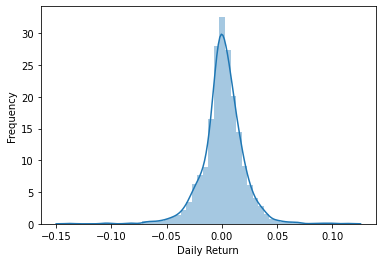

In [ ]:
log_return = np.log(1 + data.pct_change())
#Plot
sns.distplot(log_return.iloc[1:])
plt.xlabel("Daily Return")
plt.ylabel("Frequency")

[[        nan         nan         nan ...         nan -0.098111
          nan]
 [        nan         nan         nan ...         nan  0.2237009
          nan]
 [        nan         nan         nan ... -0.83141937 -0.03110109
          nan]
 ...
 [-0.05467739 -0.53153102         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
  -2.24941858]
 [        nan         nan         nan ...         nan -1.32302299
          nan]]


/home/fedeb/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/fedeb/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2589: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/home/fedeb/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/fedeb/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


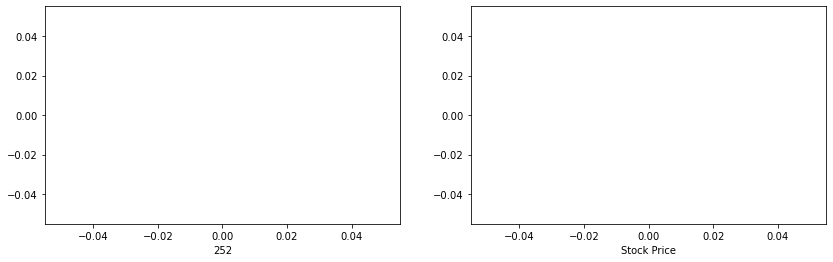

AAPL
Days: 252
Expected Value: $nan
Return: nan%


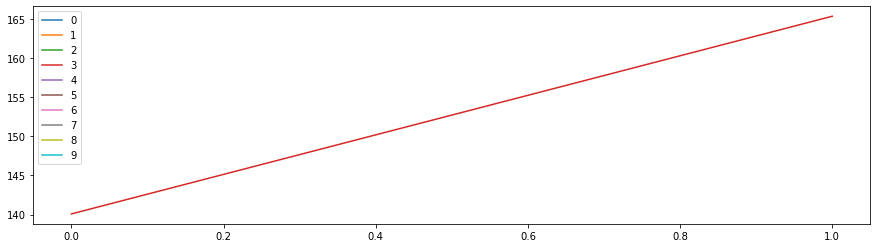

In [ ]:
ret_sim_df = monte_carlo(data, tickers, 252, 10000,  start_date=start_date, plotten=True)